# Neural Receiver for OFDM SIMO Systems

In this notebook, you will learn how to train a neural receiver that implements OFDM detection.
The considered setup is shown in the figure below.
As one can see, the neural receiver substitutes channel estimation, equalization, and demapping.
It takes as input the post-DFT (discrete Fourier transform) received samples, which form the received resource grid, and computes log-likelihood ratios (LLRs) on the transmitted coded bits.
These LLRs are then fed to the outer decoder to reconstruct the transmitted information bits.

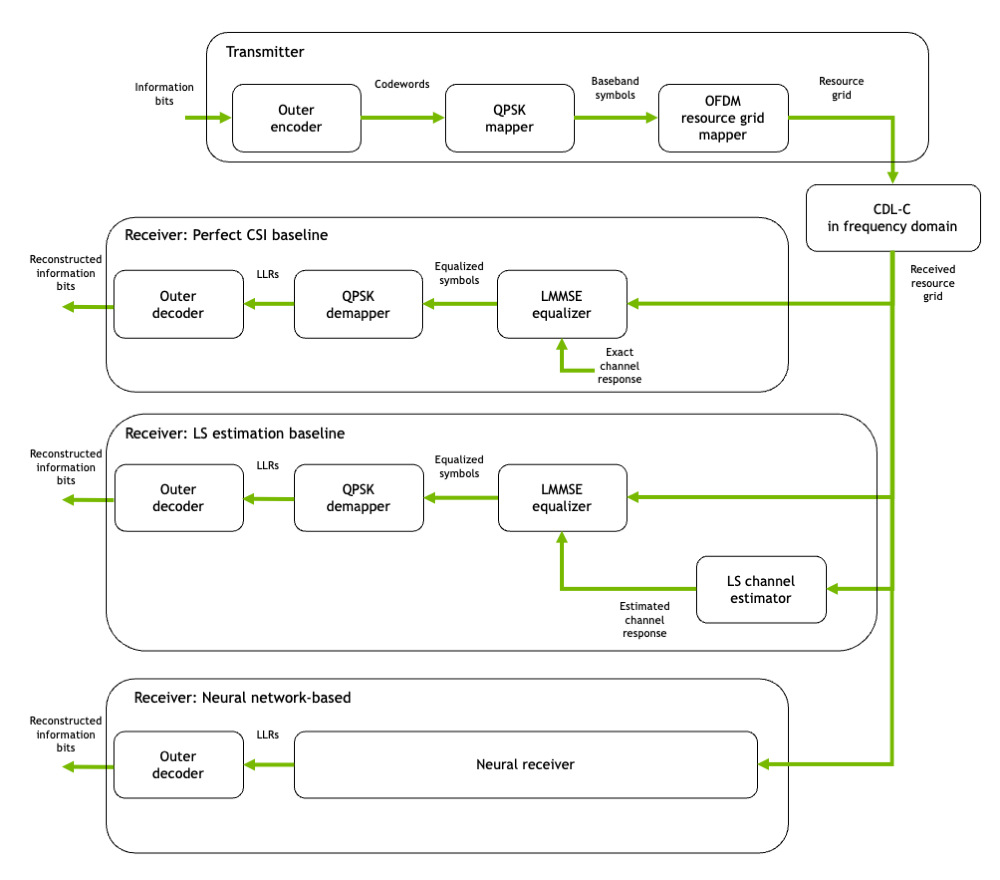

Two baselines are considered for benchmarking, which are shown in the figure above.
Both baselines use linear minimum mean square error (LMMSE) equalization and demapping assuming additive white Gaussian noise (AWGN).
They differ by how channel estimation is performed:

- **Pefect CSI**: Perfect channel state information (CSI) knowledge is assumed.
- **LS estimation**: Uses the transmitted pilots to perform least squares (LS) estimation of the channel with nearest-neighbor interpolation.

All the considered end-to-end systems use an LDPC outer code from the 5G NR specification, QPSK modulation, and a 3GPP CDL channel model simulated in the frequency domain.

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Receiver](#Neural-Receiver)
* [End-to-end System](#End-to-end-System)
* [End-to-end System as a Keras Model](#End-to-end-System-as-a-Keras-Model)
* [Evaluation of the Baselines](#Evaluation-of-the-Baselines)
* [Training the Neural Receiver](#Training-the-Neural-Receiver)
* [Evaluation of the Neural Receiver](#Evaluation-of-the-Neural-Receiver)
* [Pre-computed Results](#Pre-computed-Results)
* [References](#References)

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to use
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 1
Only GPU number 0 used.


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.fec.conv import ConvEncoder, ViterbiDecoder



from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber
from sionna.ofdm import PilotPattern, RemoveNulledSubcarriers

In [16]:
import math
import itertools

## Simulation Parameters <a class="anchor" id="Simulation-Parameters"></a>

In [10]:
############################################
## Channel configuration
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 312.5e3/2 # Hz
fft_size = 64 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 20 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 4 # 16-QAM
coderate = 0.5 # Coderate for LDPC code

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver

############################################
## Training configuration
num_training_iterations = 30000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

############################################
## Evaluation configuration
results_filename = "neural_receiver_results" # Location to save the results

The `StreamManagement` class is used to configure the receiver-transmitter association and the number of streams per transmitter.
A SIMO system is considered, with a single transmitter equipped with a single non-polarized antenna.
Therefore, there is only a single stream, and the receiver-transmitter association matrix is $[1]$.
The receiver is equipped with an antenna array.

In [11]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter

**Generate 802.11p pilot pattern**

In [17]:
short_training_symbol=math.sqrt(13/6) * np.array([0, 0, 1+1j, 0, 0, 0, -1-1j, 0, 0, 0,
    1+1j, 0, 0, 0, -1-1j, 0, 0, 0, -1-1j, 0, 0, 0, 1+1j, 0, 0, 0, 0, 0,
    0, 0, -1-1j, 0, 0, 0, -1-1j, 0, 0, 0, 1+1j, 0, 0, 0, 1+1j, 0, 0, 0,
    1+1j, 0, 0, 0, 1+1j, 0,0], dtype=complex)
# print(len(short_training_symbol))

long_training_symbol=np.array([1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1,
    -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 0, 1, -1, -1, 1, 1, -1, 1, -1,
    1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1])
# print(len(long_training_symbol))

pilots=np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, -1, 0, 0, 0, 0, 0])
# print(len(pilots))

pilotpolarity=np.array([1,1,1,1, -1,-1,-1,1, -1,-1,-1,-1, 1,1,-1,1, -1,-1,1,1,
    -1,1,1,-1, 1,1,1,1, 1,1,-1,1,1,1,-1,1, 1,-1,-1,1, 1,1,-1,1,
    -1,-1,-1,1, -1,1,-1,-1, 1,-1,-1,1, 1,1,1,1, -1,-1,1,1,-1,-1,1,-1, 
    1,-1,1,1, -1,-1,-1,1, 1,-1,-1,-1, -1,1,-1,-1, 1,-1,1,1, 1,1,-1,1, 
    -1,1,-1,1,-1,-1,-1,-1, -1,1,-1,1, 1,-1,1,-1, 1,1,1,-1, -1,1,-1,-1,
    -1,1,1,1, -1,-1,-1,-1, -1,-1,-1])
# print(len(pilotpolarity))

def generate_pilot_loc_matrix(N):
    '''
    @param N: symbols additionally added to two long training symbols, and one ...
                data symbol that contains four pilots in subcarriers.
    Generate Pilot location matrix for 802.11p 
    '1' indicates a pilot, '0' indicates data or Null
    Including block and comb type pilots as defined by the standard
    Note: Null subcarriers are also included.
    Returns a matrix of 64 x (N+3)
    '''
    p1 = 7 # subcarrier Pilot location
    p2 = 21 # subcarrier Pilot location
    p3 = 43
    p4 = 57
    # N = 12
    long_pilot_loc = [0 if (ind in range(27,38) or ind == 0) else val for ind, val in enumerate(itertools.repeat(1,64))]
    # len(long_pilot_loc)
    short_pilot_loc = [1 if (ind == p1  or ind == p2 or ind == p3 or ind == p4 ) else val for ind, val in enumerate(itertools.repeat(0,64))]
    # len(short_pilot_loc)
    pilot_matrix_base = list(map(list, zip(long_pilot_loc, long_pilot_loc, short_pilot_loc)))
    pilot_matrix_base = np.array(pilot_matrix_base)
    short_pilots_rep = np.hstack([pilot_matrix_base[:,2].reshape((-1, 1))]*N)
    pilot_matrix_loc = np.concatenate((pilot_matrix_base,short_pilots_rep), 1)
    return pilot_matrix_loc

def generate_pilot_pattern_80211p(num_tx = 1,num_streams_per_tx = 1, num_ofdm_symbols = 3, num_effective_subcarriers = 52, combPilotOnly = False):
    '''
    #num_tx, num_streams_per_tx, num_ofdm_symbols, num_effective_subcar
    '''
    # Generate MASK
    num_ofdm_symbols -=3
    if combPilotOnly:
        num_pilot_symbols = 4*(num_ofdm_symbols -1)
        mask = np.zeros((num_tx,
                 num_streams_per_tx,
                 num_ofdm_symbols -1,
                 num_effective_subcarriers))
        pilots = np.zeros((num_tx,
                 num_streams_per_tx,
                 num_pilot_symbols),
                 dtype=complex)
        pilot_matrix_loc = generate_pilot_loc_matrix(num_ofdm_symbols-3)
    else:
        num_pilot_symbols =52+52 + 4*(num_ofdm_symbols -1)
        mask = np.zeros((num_tx,
                 num_streams_per_tx,
                 num_ofdm_symbols+3,
                 num_effective_subcarriers))
        pilots = np.zeros((num_tx,
                 num_streams_per_tx,
                 num_pilot_symbols +2*4),
                 dtype=complex)
        pilot_matrix_loc = generate_pilot_loc_matrix(num_ofdm_symbols)


    pilot_matrix_loc = np.roll(pilot_matrix_loc[1:],26, axis=0)[0:52].T

    # Generate CombPilots
    ij =2 
    NST = num_effective_subcarriers  #52 + 1 # imprecise Including DC for now
    pilot1 = np.array([1,1,1,-1])
    pilotIndex1 = np.block([4, 18, 33, 47]).tolist()
    # combGrid = np.zeros((num_ofdm_symbols-4,NST),dtype=complex)
    combPilots = np.zeros(num_pilot_symbols -52-52 +2*4,dtype=complex)
    for ii in range(0,num_ofdm_symbols -1 +2):
        inputiFFT1 = np.zeros(NST,dtype = complex)
        inputiFFT1[pilotIndex1] = np.zeros(len(pilotIndex1),dtype = complex)
        ij  = ij%127
        pm = pilotpolarity[ij]
        ij = ij+1
        pilot2 = pm*pilot1
        combPilots[4*ii:4*(ii+1)] = pilot2
        # #Pilots Insertion
        # inputiFFT1[5]=pilot2[0]
        # inputiFFT1[19]=pilot2[1]
        # inputiFFT1[33]=pilot2[2]
        # inputiFFT1[47]=pilot2[3]
        # combGrid[ii, :] = inputiFFT1

    if combPilotOnly:
         pilot_matrix_loc = pilot_matrix_loc[2:][:]
    else:
        pilot_matrix_loc = pilot_matrix_loc[:][:]
    # Block Pilots
    BlockPilot = np.delete(long_training_symbol,26)
         
    for indtx in range(0,num_tx):
        for indstreamtx in range(0,num_streams_per_tx):
            mask[indtx, indstreamtx, :, :] = pilot_matrix_loc
            print(mask.shape)
            print(int(np.sum(mask[0,0])))
            if combPilotOnly:
                pilots[indtx, indstreamtx, :] = combPilots
            else:
                pilots[indtx, indstreamtx, :] = np.block([ BlockPilot, BlockPilot, combPilots])
                print(pilots.shape)
    with tf.device('/cpu:0'):
        pilot_pattern_80211p = PilotPattern(mask = mask, pilots = pilots, trainable=False, normalize=False, dtype=tf.complex64)

    return pilot_pattern_80211p


The `ResourceGrid` class is used to configure the OFDM resource grid. It is initialized with the parameters defined above.

In [19]:
Nsym = num_ofdm_symbols
pilot_pattern_80211p = generate_pilot_pattern_80211p(num_tx = 1,num_streams_per_tx = 1, num_ofdm_symbols = Nsym, num_effective_subcarriers = 52, combPilotOnly = False)
num_guard_carriers = [6, 5]


(1, 1, 20, 52)
176
(1, 1, 176)


In [21]:


resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern_80211p,
                             num_guard_carriers = num_guard_carriers) 

Outer coding is performed such that all the databits carried by the resource grid with size `fft_size`x`num_ofdm_symbols` form a single codeword.

In [22]:
print(f"num_data_symbols: {resource_grid.num_data_symbols}")

num_data_symbols: 864


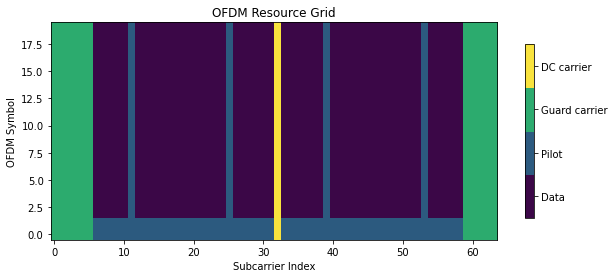

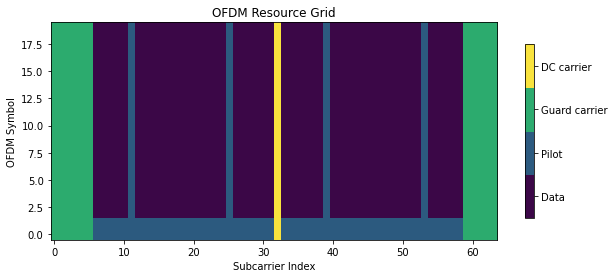

In [23]:
resource_grid.show()

In [24]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate) 

The SIMO link is setup by considering an uplink transmission with one user terminal (UT) equipped with a single non-polarized antenna, and a base station (BS) equipped with an antenna array.
One can try other configurations for the BS antenna array.

In [25]:
ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

## Neural Receiver <a class="anchor" id="Neural-Receiver"></a>

The next cell defines the Keras layers that implement the neural receiver.
As in [1] and [2], a neural receiver using residual convolutional layers is implemented. Convolutional layers are leveraged to efficienly process the 2D resource grid, that is fed as an input to the neural receiver.
Residual (skip) connections are used to avoid gradient vanishing [3].

For convinience, a Keras layer that implements a *residual block* is first defined. The Keras layer that implements the neural receiver is built by stacking such blocks. The following figure shows the architecture of the neural receiver.

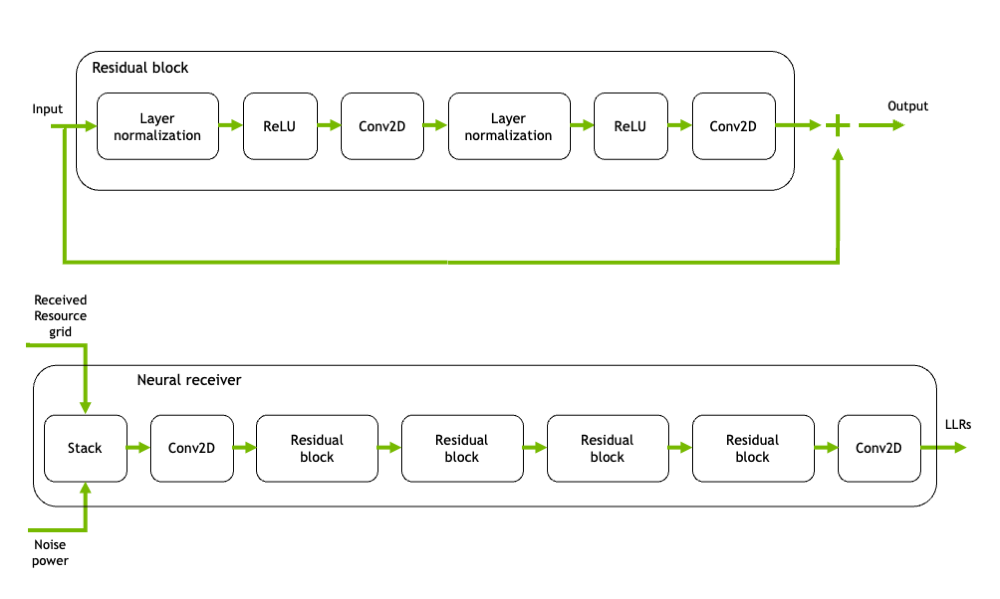

In [26]:
class ResidualBlock(Layer):
    r"""
    This Keras layer implements a convolutional residual block made of two convolutional layers with ReLU activation, layer normalization, and a skip connection.
    The number of convolutional channels of the input must match the number of kernel of the convolutional layers ``num_conv_channel`` for the skip connection to work.
    
    Input
    ------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Input of the layer
    
    Output
    -------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Output of the layer
    """
                        
    def build(self, input_shape):
        
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
    
    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs
        
        return z

class NeuralReceiver(Layer):
    r"""
    Keras layer implementing a residual convolutional neural receiver.
    
    This neural receiver is fed with the post-DFT received samples, forming a resource grid of size num_of_symbols x fft_size, and computes LLRs on the transmitted coded bits.
    These LLRs can then be fed to an outer decoder to reconstruct the information bits.
    
    As the neural receiver is fed with the entire resource grid, including the guard bands and pilots, it also computes LLRs for these resource elements.
    They must be discarded to only keep the LLRs corresponding to the data-carrying resource elements.
    
    Input
    ------
    y : [batch size, num rx antenna, num ofdm symbols, num subcarriers], tf.complex
        Received post-DFT samples.
    
    no : [batch size], tf.float32
        Noise variance. At training, a different noise variance value is sampled for each batch example.
    
    Output
    -------
    : [batch size, num ofdm symbols, num subcarriers, num_bits_per_symbol]
        LLRs on the transmitted bits.
        LLRs computed for resource elements not carrying data (pilots, guard bands...) must be discarded.
    """
    
    def build(self, input_shape):
        
        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)
        
    def call(self, inputs):
        y, no = inputs
        
        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)
        
        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)
        
        return z

## End-to-end System <a class="anchor" id="End-to-end-System"></a>

The following cell defines the end-to-end system.

Training is done on the bit-metric decoding (BMD) rate which is computed from the transmitted bits and LLRs:

\begin{equation}
R = 1 - \frac{1}{SNMK} \sum_{s = 0}^{S-1} \sum_{n = 0}^{N-1} \sum_{m = 0}^{M-1} \sum_{k = 0}^{K-1} \texttt{BCE} \left( B_{s,n,m,k}, \texttt{LLR}_{s,n,m,k} \right)
\end{equation}

where

* $S$ is the batch size
* $N$ the number of subcarriers
* $M$ the number of OFDM symbols
* $K$ the number of bits per symbol
* $B_{s,n,m,k}$ the $k^{th}$ coded bit transmitted on the resource element $(n,m)$ and for the $s^{th}$ batch example
* $\texttt{LLR}_{s,n,m,k}$ the LLR (logit) computed by the neural receiver corresponding to the $k^{th}$ coded bit transmitted on the resource element $(n,m)$ and for the $s^{th}$ batch example
* $\texttt{BCE} \left( \cdot, \cdot \right)$ the binary cross-entropy in log base 2

Because no outer code is required at training, the outer encoder and decoder are not used at training to reduce computational complexity.

The BMD rate is known to be an achievable information rate for BICM systems, which motivates its used as objective function [4].

In [28]:
## Transmitter
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

## Receiver
neural_receiver = NeuralReceiver()
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

The following cell performs one forward step through the end-to-end system:

In [29]:
batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)


## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)

######################################
## Channel
# A batch of new channel realizations is sampled and applied at every inference
no_ = expand_to_rank(no, tf.rank(x_rg))
y,_ = channel([x_rg, no_])
print("y shape: ", y.shape)

######################################
## Receiver       
# The neural receover computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (64, 1, 1, 3456)
x shape:  (64, 1, 1, 864)
x_rg shape:  (64, 1, 1, 20, 64)
y shape:  (64, 1, 2, 20, 64)
llr shape:  (64, 20, 64, 4)
Post RG-demapper LLRs:  (64, 1, 1, 3456)


The BMD rate is computed from the LLRs and transmitted bits as follows:

In [30]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: -2.97E-01 bit


The rate is very poor (negative values means 0 bit) as the neural receiver is not trained.

## End-to-end System as a Keras Model <a class="anchor" id="End-to-end-System-as-a-Keras-Model"></a>

The following Keras *Model* implements the three considered end-to-end systems (perfect CSI baseline, LS estimation baseline, and neural receiver).

When instantiating the Keras model, the parameter ``system`` is used to specify the system to setup, and the parameter ``training`` is used to specified if the system is instantiated to be trained or to be evaluated. The ``training`` parameter is only relevant when the neural receiver is used.

At each call of this model:

* A batch of codewords is randomly sampled, modulated, and mapped to resource grids to form the channel inputs
* A batch of channel realizations is randomly sampled and applied to the channel inputs
* The receiver is executed on the post-DFT received samples to compute LLRs on the coded bits.
  Which receiver is executed (baseline with perfect CSI knowledge, baseline with LS estimation, or neural receiver) depends on the specified ``system`` parameter.
* If not training, the outer decoder is applied to reconstruct the information bits
* If training, the BMD rate is estimated over the batch from the LLRs and the transmitted bits


In [34]:
class E2ESystem(Model):
    r"""
    Keras model that implements the end-to-end systems.
    
    As the three considered end-to-end systems (perfect CSI baseline, LS estimation baseline, and neural receiver) share most of
    the link components (transmitter, channel model, outer code...), they are implemented using the same Keras model.

    When instantiating the Keras model, the parameter ``system`` is used to specify the system to setup,
    and the parameter ``training`` is used to specified if the system is instantiated to be trained or to be evaluated.
    The ``training`` parameter is only relevant when the neural 
    
    At each call of this model:
    * A batch of codewords is randomly sampled, modulated, and mapped to resource grids to form the channel inputs
    * A batch of channel realizations is randomly sampled and applied to the channel inputs
    * The receiver is executed on the post-DFT received samples to compute LLRs on the coded bits.
      Which receiver is executed (baseline with perfect CSI knowledge, baseline with LS estimation, or neural receiver) depends
      on the specified ``system`` parameter.
    * If not training, the outer decoder is applied to reconstruct the information bits
    * If training, the BMD rate is estimated over the batch from the LLRs and the transmitted bits
    
    Parameters
    -----------
    system : str
        Specify the receiver to use. Should be one of 'baseline-perfect-csi', 'baseline-ls-estimation' or 'neural-receiver'
    
    training : bool
        Set to `True` if the system is instantiated to be trained. Set to `False` otherwise. Defaults to `False`.
        If the system is instantiated to be trained, the outer encoder and decoder are not instantiated as they are not required for training.
        This significantly reduces the computational complexity of training.
        If training, the bit-metric decoding (BMD) rate is computed from the transmitted bits and the LLRs. The BMD rate is known to be
        an achievable information rate for BICM systems, and therefore training of the neural receiver aims at maximizing this rate.
    
    Input
    ------
    batch_size : int
        Batch size
    
    no : scalar or [batch_size], tf.float
        Noise variance.
        At training, a different noise variance should be sampled for each batch example.
    
    Output
    -------
    If ``training`` is set to `True`, then the output is a single scalar, which is an estimation of the BMD rate computed over the batch. It
    should be used as objective for training.
    If ``training`` is set to `False`, the transmitted information bits and their reconstruction on the receiver side are returned to
    compute the block/bit error rate. 
    """
    
    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training
    
        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = ConvEncoder(rate=k/n, constraint_length=7)# ConvEncoder(k, n, 7)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        
        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)
        
        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of `system`
        if "baseline" in system:
            if system == 'baseline-perfect-csi': # Perfect CSI
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation': # LS estimation
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            # Components required by both baselines
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        elif system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._decoder = ViterbiDecoder(self._encoder) #LDPC5GDecoder(self._encoder, hard_out=True)
    
    @tf.function
    def call(self, batch_size, ebno_db):
        
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        
        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        
        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y,h = self._channel([x_rg, no_])
        
        ######################################
        ## Receiver       
        # Three options for the receiver depending on the value of ``system``
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h) # Extract non-null subcarriers
                err_var = 0.0 # No channel estimation error when perfect CSI knowledge is assumed
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est([y, no]) # LS channel estimation with nearest-neighbor
            x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
            no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper([x_hat, no_eff_]) # Demapping
        elif self._system == "neural-receiver":
            # The neural receover computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected

        # Outer coding is not needed if the information rate is returned
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

## Evaluation of the Baselines <a class="anchor" id="Evaluation-of-the-Baselines"></a>

We evaluate the BERs achieved by the baselines in the next cell.

**Note:** Evaluation of the two systems can take a while. Therefore, we provide pre-computed results at the end of this notebook.

In [35]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [36]:
# Dictionnary storing the evaluation results
BLER = {}

model = E2ESystem('baseline-perfect-csi')
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-perfect-csi'] = bler.numpy()

model = E2ESystem('baseline-ls-estimation')
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-ls-estimation'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.7641e-01 | 1.0000e+00 |      105375 |      221184 |          128 |         128 |        16.7 |reached target block errors
     -4.5 | 4.7089e-01 | 1.0000e+00 |      104154 |      221184 |          128 |         128 |         4.4 |reached target block errors
     -4.0 | 4.5379e-01 | 1.0000e+00 |      100370 |      221184 |          128 |         128 |         4.4 |reached target block errors
     -3.5 | 4.2999e-01 | 1.0000e+00 |       95106 |      221184 |          128 |         128 |         4.2 |reached target block errors
     -3.0 | 4.0435e-01 | 1.0000e+00 |       89435 |      221184 |          128 |         128 |         4.2 |reached target block errors
     -2.5 | 3.5960e-01 | 1.0000e+00 |       79538 |      221184 |

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.9938e-01 | 1.0000e+00 |      110455 |      221184 |          128 |         128 |         8.2 |reached target block errors
     -4.5 | 4.9993e-01 | 1.0000e+00 |      110577 |      221184 |          128 |         128 |         4.2 |reached target block errors
     -4.0 | 4.9916e-01 | 1.0000e+00 |      110407 |      221184 |          128 |         128 |         4.3 |reached target block errors
     -3.5 | 4.9943e-01 | 1.0000e+00 |      110467 |      221184 |          128 |         128 |         4.2 |reached target block errors
     -3.0 | 4.9859e-01 | 1.0000e+00 |      110281 |      221184 |          128 |         128 |         4.1 |reached target block errors
     -2.5 | 4.9651e-01 | 1.0000e+00 |      109821 |      221184 |

## Training the Neural Receiver <a class="anchor" id="Training-the-Neural-Receiver"></a>

In the next cell, one forward pass is performed within a *gradient tape*, which enables the computation of gradient and therefore the optimization of the neural network through stochastic gradient descent (SGD).

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part2.html).

In [37]:
# The end-to-end system equipped with the neural receiver is instantiated for training.
# When called, it therefore returns the estimated BMD rate
model = E2ESystem('neural-receiver', training=True)

# Sampling a batch of SNRs
ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
# Forward pass
with tf.GradientTape() as tape:
    rate = model(training_batch_size, ebno_db)
    # Tensorflow optimizers only know how to minimize loss function.
    # Therefore, a loss function is defined as the additive inverse of the BMD rate
    loss = -rate

Next, one can perform one step of stochastic gradient descent (SGD).
The Adam optimizer is used

In [38]:
optimizer = tf.keras.optimizers.Adam()

# Computing and applying gradients        
weights = model.trainable_weights
grads = tape.gradient(loss, weights)
optimizer.apply_gradients(zip(grads, weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

Training consists in looping over SGD steps. The next cell implements a training loop.

At each iteration:
- A batch of SNRs $E_b/N_0$ is sampled
- A forward pass through the end-to-end system is performed within a gradient tape
- The gradients are computed using the gradient tape, and applied using the Adam optimizer
- The achieved BMD rate is periodically shown

After training, the weights of the models are saved in a file

**Note:** Training can take a while. Therefore, pre-trained weights are made available with this notebook. Do not execute the next cell if you don't want to train the model from scratch. 

In [39]:
model = E2ESystem('neural-receiver', training=True)

optimizer = tf.keras.optimizers.Adam()

for i in range(num_training_iterations):
    # Sampling a batch of SNRs
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    # Forward pass
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db)
        # Tensorflow optimizers only know how to minimize loss function.
        # Therefore, a loss function is defined as the additive inverse of the BMD rate
        loss = -rate
    # Computing and applying gradients        
    weights = model.trainable_weights
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    # Periodically printing the progress
    if i % 100 == 0:
        print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')

# Save the weights in a file
weights = model.get_weights()
with open(model_weights_path, 'wb') as f:
    pickle.dump(weights, f)

## Evaluation of the Neural Receiver <a class="anchor" id="Evaluation-of-the-Neural-Receiver"></a>

The next cell evaluates the neural receiver.

**Note:** Evaluation of the system can take a while and requires having the trained weights of the neural receiver. Therefore, we provide pre-computed results at the end of this notebook.

In [40]:
model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

# Evaluations
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver'] = bler.numpy()


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.7909e-01 | 1.0000e+00 |      105968 |      221184 |          128 |         128 |         4.1 |reached target block errors
     -4.5 | 4.7448e-01 | 1.0000e+00 |      104948 |      221184 |          128 |         128 |         4.1 |reached target block errors
     -4.0 | 4.6149e-01 | 1.0000e+00 |      102074 |      221184 |          128 |         128 |         4.2 |reached target block errors
     -3.5 | 4.4301e-01 | 1.0000e+00 |       97987 |      221184 |          128 |         128 |         4.1 |reached target block errors
     -3.0 | 4.1898e-01 | 1.0000e+00 |       92672 |      221184 |          128 |         128 |         4.3 |reached target block errors
     -2.5 | 3.8018e-01 | 1.0000e+00 |       84089 |      221184 |

Finally, we plots the BLERs

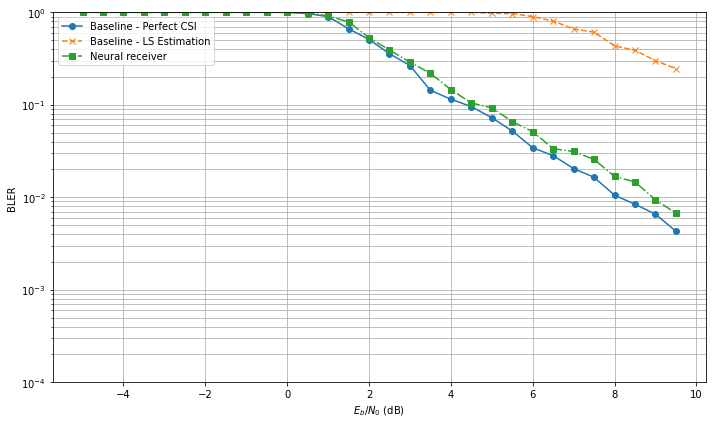

In [41]:
plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BLER['baseline-perfect-csi'], 'o-', c=f'C0', label=f'Baseline - Perfect CSI')    
# Baseline - LS Estimation
plt.semilogy(ebno_dbs, BLER['baseline-ls-estimation'], 'x--', c=f'C1', label=f'Baseline - LS Estimation')
# Neural receiver
plt.semilogy(ebno_dbs, BLER['neural-receiver'], 's-.', c=f'C2', label=f'Neural receiver')
#
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()

## Pre-computed Results <a class="anchor" id="Pre-computed-Results"></a>

In [42]:
pre_computed_results = "{'baseline-perfect-csi': [1.0, 1.0, 1.0, 1.0, 1.0, 0.9916930379746836, 0.5367080479452054, 0.0285078125, 0.0017890625, 0.0006171875, 0.0002265625, 9.375e-05, 2.34375e-05, 7.8125e-06, 1.5625e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baseline-ls-estimation': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998022151898734, 0.9199448529411764, 0.25374190938511326, 0.0110234375, 0.002078125, 0.0008359375, 0.0004375, 0.000171875, 9.375e-05, 4.6875e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'neural-receiver': [1.0, 1.0, 1.0, 1.0, 1.0, 0.9984177215189873, 0.7505952380952381, 0.10016025641025642, 0.00740625, 0.0021640625, 0.000984375, 0.0003671875, 0.000203125, 0.0001484375, 3.125e-05, 2.34375e-05, 7.8125e-06, 7.8125e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}"
BLER = eval(pre_computed_results)

## References <a class="anchor" id="References"></a>

[1] M. Honkala, D. Korpi and J. M. J. Huttunen, "DeepRx: Fully Convolutional Deep Learning Receiver," in IEEE Transactions on Wireless Communications, vol. 20, no. 6, pp. 3925-3940, June 2021, doi: 10.1109/TWC.2021.3054520.

[2] F. Ait Aoudia and J. Hoydis, "End-to-end Learning for OFDM: From Neural Receivers to Pilotless Communication," in IEEE Transactions on Wireless Communications, doi: 10.1109/TWC.2021.3101364.

[3] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, "Deep Residual Learning for Image Recognition", Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778

[4] G. Böcherer, "Achievable Rates for Probabilistic Shaping", arXiv:1707.01134, 2017.